# Mapping and detecting slums in Kampala Uganda.



In [2]:
#Import necessary Libraries
!pip install momepy
!pip install osmnx
!pip install PyDrive
!pip install clustergram
!pip install folium matplotlib mapclassify
!pip install shapely
!pip install matplotlib-scalebar
!pip install basemap

import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import momepy as mm
import pyproj
import osmnx as ox
import libpysal
from shapely.geometry import box
from time import time
from clustergram import Clustergram
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bokeh.io import output_notebook
from bokeh.plotting import show
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.basemap import Basemap

from shapely.geometry import LineString
from shapely.geometry import Point

# Usage of osmnx to get the data

In [17]:
point = (0.335044, 32.575066) 
dist = 1000
gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
gdf2 = ox.geometries.geometries_from_point(point, dist=dist, tags={'residential':['irregular_settlement']})
gdf_projected = ox.projection.project_gdf(gdf)
gdf_projected_2 = ox.projection.project_gdf(gdf2)
buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]
Katanga = gdf_projected_2[gdf_projected_2.geom_type.isin(['Polygon', 'MultiPolygon'])]

buildings['uID'] = mm.unique_id(buildings)
Katanga['uID'] = mm.unique_id(Katanga)
limit = mm.buffered_limit(buildings) # this define limit for momepy.Tessellation as a buffer around buildings.
tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

# Ensure that Korail is a single polygon (dissolve if there are multiple polygons)
Katanga_union = Katanga.unary_union

C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\osmnx\geometries.py:816: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_inner_linestring in list(merged_inner_linestrings):
C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\osmnx\geometries.py:816: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_inner_linestring in list(merged_inner_linestrings):

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\momepy\elements.py:396: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [1080, 1327, 2417, 2461, 2543, 4081, 4109, 4240, 4736, 4896, 5437]
  "Tessellation contains MultiPolygon elements. Initial objects should "


In [18]:
#Number of buildings obtained for training dataset
total_buildings = len(buildings)
print(f"Total number of buildings: {total_buildings}")

Total number of buildings: 5466


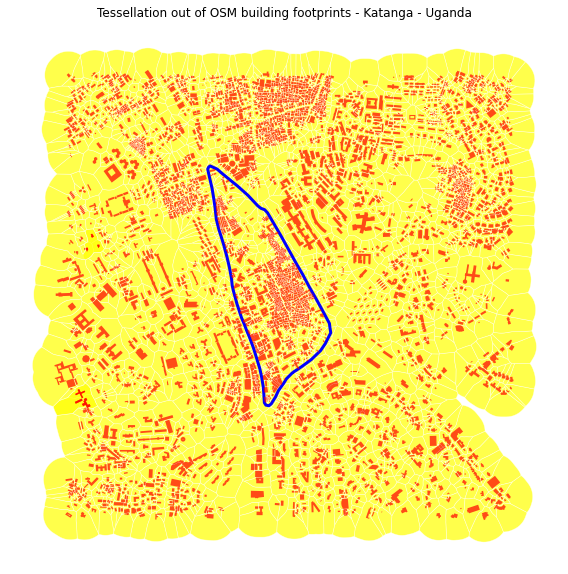

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', legend=True, linewidth=0.5, facecolor='yellow', alpha=.7)
Katanga.plot(ax=ax, edgecolor='blue', legend=True, facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', legend=True, alpha=.7)
plt.title('Tessellation out of OSM building footprints - Katanga - Uganda')
ax.set_axis_off()
plt.show()

## Areas
Building areas

In [22]:
blg_area = mm.Area(buildings)
buildings['area'] = blg_area.series

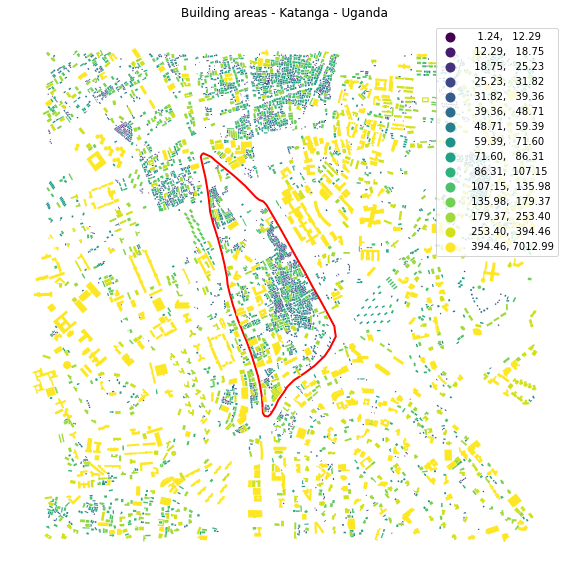

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
buildings.plot(ax=ax, column='area', legend=True, scheme='quantiles', k=15, cmap='viridis')
plt.title('Building areas - Katanga - Uganda')
ax.set_axis_off()
plt.show()

## **SPATIAL DISTRIBUTION METRICS**

# Distance to neighbours buidlings

Caculates the distance to neighbours buildings through queen contiguity weights of the first order capturing the relationship between immediate neighbours.Relationship between buildings is here represented by relationships between their tessellation cells.

In [24]:
sw1 = mm.sw_high(k=1, gdf=tessellation, ids='uID')
buildings['neighbour_dist'] = mm.NeighborDistance(buildings, sw1, 'uID').series
buildings = buildings.dropna(subset=['neighbour_dist'])

C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
C:\Users\eares\anaconda3\envs\GEO36\lib\site-packages\libpysal\weights\_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
100%|██████████| 5466/5466 [00:08<00:00, 674.44it/s]


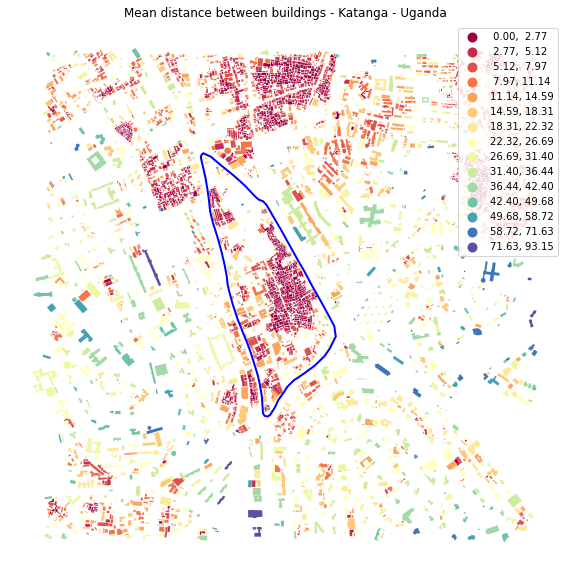

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='neighbour_dist', scheme='naturalbreaks', k=15, legend=True, cmap='Spectral')
Katanga.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)
plt.title('Mean distance between buildings - Katanga - Uganda')
ax.set_axis_off()
plt.show()

# Mean Interbuilding Distance

 Interbuilding distances are calculated between buildings on adjacent cells based on spatial_weights,

In [26]:
MID = mm.MeanInterbuildingDistance(buildings, sw1,'uID')
buildings['mean_interbuilding_distance'] = MID.series


Computing mean interbuilding distances...


100%|██████████| 5466/5466 [00:12<00:00, 445.76it/s]


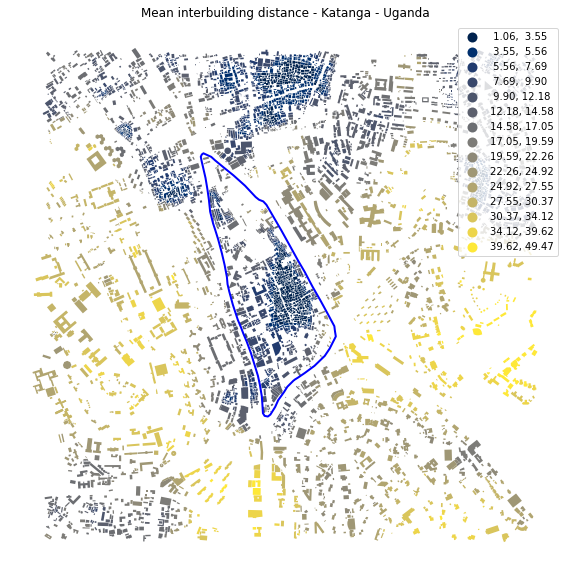

In [27]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='mean_interbuilding_distance', scheme='naturalbreaks', k=15, legend=True, cmap='cividis')
Katanga.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)
plt.title('Mean interbuilding distance - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [28]:
print(buildings.columns)

Index(['geometry', 'amenity', 'name', 'multipurpose', 'nodes', 'addr:city',
       'addr:housename', 'addr:housenumber', 'addr:street', 'building',
       'source', 'wikidata', 'ref', 'building:condition', 'building:levels',
       'building:material', 'department', 'denomination', 'religion',
       'operator', 'residential', 'shop', 'addr:country', 'office',
       'short_name', 'website', 'opening_hours', 'government', 'healthcare',
       'note', 'addr:postcode', 'layer', 'tourism', 'nohousenumber',
       'source:date', 'smoking', 'level', 'brand', 'contact:facebook',
       'contact:instagram', 'contact:twitter', 'internet_access',
       'internet_access:fee', 'phone', 'rooms', 'wheelchair', 'name:zh',
       'community_centre', 'roof:levels', 'fixme', 'height', 'outdoor_seating',
       'roof:colour', 'roof:shape', 'historic', 'ways', 'type', 'addr:unit',
       'email', 'description', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance'],
      dtype='object')

In [145]:
# features = buildings[['area', 'neighbour_dist', 'mean_interbuilding_distance']]
# print(buildings.head())

# TOPOLOGY METRICS

# Obtain basic dataset = Centroids of the buildings

In [29]:
# Centroids of the buildings
def multipolygon_centroid(geom):
    if geom.geom_type == 'MultiPolygon':
        return geom.convex_hull.centroid
    else:
        return geom.centroid

buildings['centroid'] = buildings.geometry.apply(multipolygon_centroid)

# Create a GeoDataFrame for the centroids with uID
centroids_gdf = gpd.GeoDataFrame({
    'uID': buildings['uID'],
    'geometry': buildings['centroid']
}, crs=buildings.crs)

In [30]:
print(buildings.columns)

Index(['geometry', 'amenity', 'name', 'multipurpose', 'nodes', 'addr:city',
       'addr:housename', 'addr:housenumber', 'addr:street', 'building',
       'source', 'wikidata', 'ref', 'building:condition', 'building:levels',
       'building:material', 'department', 'denomination', 'religion',
       'operator', 'residential', 'shop', 'addr:country', 'office',
       'short_name', 'website', 'opening_hours', 'government', 'healthcare',
       'note', 'addr:postcode', 'layer', 'tourism', 'nohousenumber',
       'source:date', 'smoking', 'level', 'brand', 'contact:facebook',
       'contact:instagram', 'contact:twitter', 'internet_access',
       'internet_access:fee', 'phone', 'rooms', 'wheelchair', 'name:zh',
       'community_centre', 'roof:levels', 'fixme', 'height', 'outdoor_seating',
       'roof:colour', 'roof:shape', 'historic', 'ways', 'type', 'addr:unit',
       'email', 'description', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance', 'centroid'],
      dty

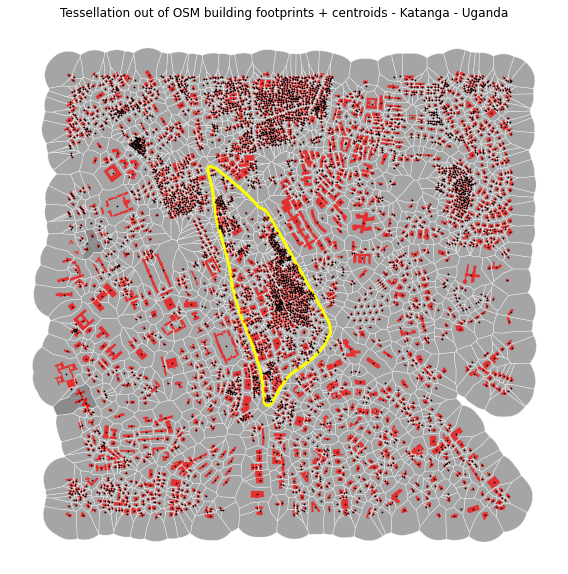

In [31]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='grey', alpha=.7)
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', alpha=.7)
centroids_gdf.plot(ax=ax, color='black', markersize=0.5, marker='o', label='Centroids')
plt.title('Tessellation out of OSM building footprints + centroids - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [33]:
total_nodes = len(centroids_gdf)
print(f"Total number of nodes: {total_nodes}")
total_buildings = len(buildings)
print(f"Total number of buildings: {total_buildings}")

Total number of nodes: 5466
Total number of buildings: 5466


# Delaunay Triangulation

In [34]:
#Coordinates based on the centroids of the buildings
coordinates = np.column_stack((centroids_gdf.geometry.x, centroids_gdf.geometry.y))

from scipy.spatial import Delaunay
tri = Delaunay(coordinates)

# Create a networkx graph out of the Delaunay triangulation
G = nx.Graph()

# Add edges to the graph
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            G.add_edge(simplex[i], simplex[j])

# Get positions of the nodes for plotting
positions = {i: (coordinates[i, 0], coordinates[i, 1]) for i in range(len(coordinates))}

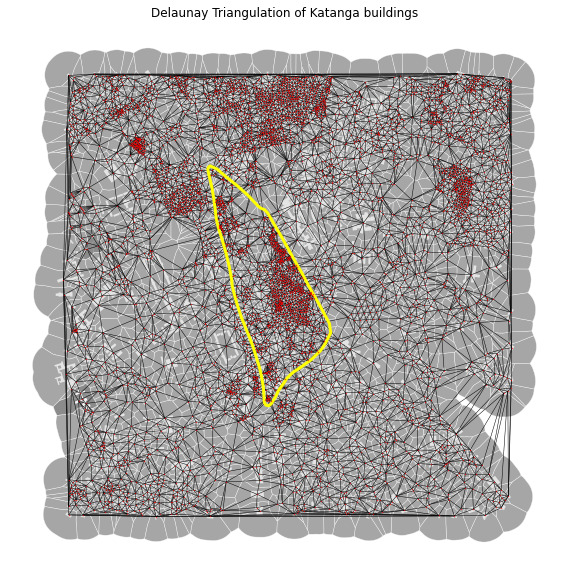

In [35]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='grey', alpha=.7)
buildings.plot(ax=ax, color='white', alpha=.7)

# Edges of the Delaunay triangulation
nx.draw(G, pos=positions, node_size=0.1, node_color='red', edge_color='black', width=0.5)
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
plt.title('Delaunay Triangulation of Katanga buildings')
plt.show()

# Weighted distance

In [36]:
# Edges to the graph with weights based on Euclidean distance
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            p1 = coordinates[simplex[i]]
            p2 = coordinates[simplex[j]]
            distance = euclidean(p1, p2) #scipy
            G.add_edge(simplex[i], simplex[j], weight=distance) #networkx

# Extract edges with their weights
edges = []
for u, v, data in G.edges(data=True):
    line = LineString([coordinates[u], coordinates[v]])
    edges.append({'geometry': line, 'weight': data['weight']})

# Geodataframe of edges
gdf_edges = gpd.GeoDataFrame(edges)

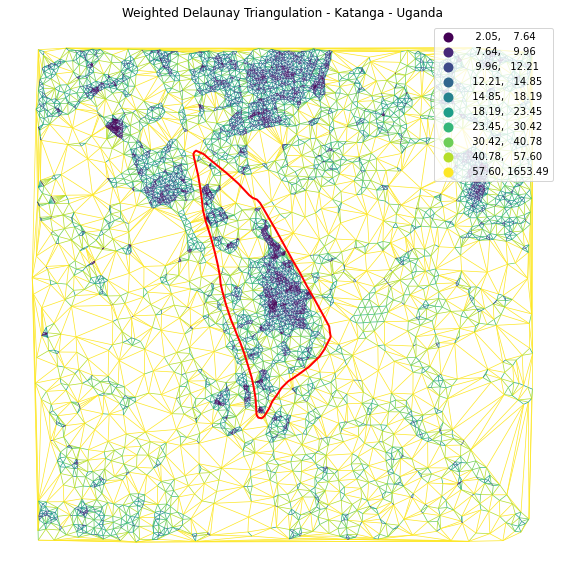

In [37]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)

# centroids_gdf.plot(ax=ax, color='grey', markersize=0.5, marker='o', label='Centroids', zorder=5)

gdf_edges.plot(ax=ax, column='weight', legend=True, scheme='quantiles', k=10, cmap='viridis', linewidth=0.7, zorder=0)

plt.title('Weighted Delaunay Triangulation - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [38]:
# Initialize a dictionary to store average weighted distances for each node
node_avg_weighted_distance = {}

# Loop through each node in the graph
for node in G.nodes():
    # Get all neighboring nodes (adjacent nodes)
    neighbors = list(G.neighbors(node))

    # Calculate average weighted distance
    total_weighted_distance = 0.0
    count = 0

    # Iterate over edges connecting the node to its neighbors
    for neighbor in neighbors:
        # Get the weight of the edge between node and neighbor
        weight = G[node][neighbor]['weight']

        # Accumulate weighted distance
        total_weighted_distance += weight
        count += 1

    # Calculate average weighted distance for the node
    if count > 0:
        avg_weighted_distance = total_weighted_distance / count
    else:
        avg_weighted_distance = 0.0

    # Store the average weighted distance in the dictionary
    node_avg_weighted_distance[node] = avg_weighted_distance

# Print or use node_avg_weighted_distance as needed
print(node_avg_weighted_distance)

{5351: 174.15547674210532, 1470: 137.05763067305702, 1485: 97.46445153112741, 12: 290.9914371876717, 20: 67.8264654612279, 302: 120.31167828685216, 5433: 257.90607356314825, 9: 167.48294605575688, 19: 69.62476913831115, 227: 124.9507518098352, 589: 75.49385903188663, 577: 60.87315557436949, 590: 54.434172982476035, 591: 47.504404573127935, 5378: 48.187151928527655, 575: 52.955640728056245, 2703: 250.87114985786937, 2702: 106.70183515047425, 572: 189.63178115341898, 710: 46.76162517982696, 711: 38.896459763114414, 420: 83.49003188847972, 1520: 52.65430384738561, 1653: 34.45176970656223, 712: 28.074322696750958, 5361: 41.826110854698925, 1512: 61.192216028215704, 981: 73.82559317490117, 969: 64.9535013934326, 965: 65.94486382749326, 5269: 19.132250322292172, 5258: 18.20485902899733, 5266: 66.9048433897887, 4404: 82.77942467154426, 4403: 150.6166320895485, 2133: 83.58337482883493, 369: 51.4080926432759, 1924: 39.92982279599067, 1947: 245.92616226340817, 5451: 138.89425320833527, 1946: 140

   avg_weighted_distance
0              42.172372
1              38.136753
2              49.787743
3              34.686036
4              35.554575


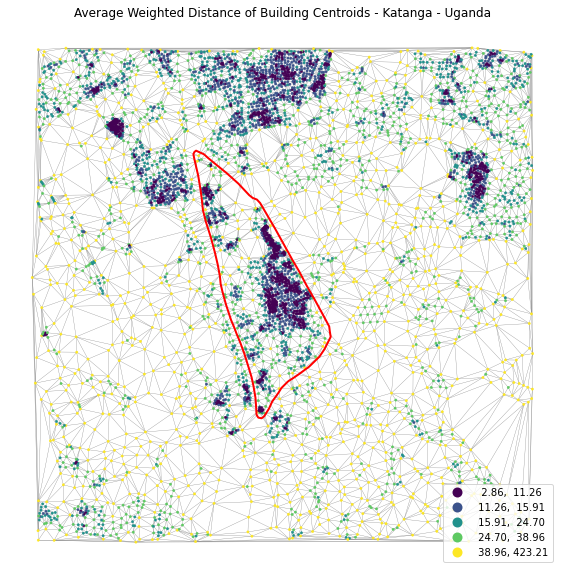

In [39]:
# Ensure that the GeoDataFrame indices match the graph nodes
centroids_gdf = centroids_gdf.reset_index(drop=True)


# Map the average weighted distances to the GeoDataFrame
centroids_gdf['avg_weighted_distance'] = centroids_gdf.index.map(node_avg_weighted_distance)

# Verify the mapping
print(centroids_gdf[['avg_weighted_distance']].head())

# Plot to visualize the average weighted distances
f, ax = plt.subplots(figsize=(10, 10))

# Ensure avg_weighted_distance column exists and is not empty
if 'avg_weighted_distance' in centroids_gdf.columns and not centroids_gdf['avg_weighted_distance'].isnull().all():
    Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)
    centroids_gdf.plot(ax=ax, column='avg_weighted_distance',  legend=True, scheme='quantiles', cmap='viridis', markersize=5, linewidth=0.5, zorder=5)
    gdf_edges.plot(ax=ax, color='grey', linewidth=0.3, zorder=0)
    plt.title('Average Weighted Distance of Building Centroids - Katanga - Uganda')
    ax.set_axis_off()
    plt.show()
else:
    print("Average weighted distance data is missing or empty.")

In [40]:
total_nodes = len(centroids_gdf)
print(f"Total number of nodes: {total_nodes}")
#same amount of nodes to buildings :)

Total number of nodes: 5466


In [157]:
print(buildings.columns)

Index(['geometry', 'name', 'nodes', 'building', 'source', 'wikidata', 'ref',
       'department', 'building:levels', 'operator', 'residential', 'shop',
       'amenity', 'religion', 'addr:city', 'addr:country', 'addr:housenumber',
       'addr:street', 'office', 'opening_hours', 'government', 'healthcare',
       'smoking', 'multipurpose', 'fixme', 'height', 'nohousenumber', 'layer',
       'roof:colour', 'wheelchair', 'building:material', 'roof:shape',
       'historic', 'ways', 'type', 'addr:postcode', 'addr:unit', 'email',
       'description', 'note', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance', 'centroid'],
      dtype='object')


# Spatial Joint MM and TP

In [41]:
# Spatial join using geopandas.sjoin
# Merge buildings and centroids_gdf, ensuring we retain the geometry column
joined_gdf = gpd.GeoDataFrame(
    buildings.merge(centroids_gdf, on='uID', suffixes=('_building', '_centroid')),
    geometry='geometry_building',  # Assuming 'geometry_building' is the name of the geometry column after merging
    crs=buildings.crs  # Ensure the coordinate reference system is retained
)

# Check the first few rows to verify the join


print(joined_gdf.head())
print(joined_gdf.geom_type)

                                   geometry_building amenity name  \
0  POLYGON ((453105.028 36239.305, 453102.091 362...     NaN  NaN   
1  POLYGON ((453128.086 36265.545, 453133.683 362...     NaN  NaN   
2  POLYGON ((453176.748 36298.217, 453183.659 363...     NaN  NaN   
3  POLYGON ((453172.609 36297.940, 453161.102 362...     NaN  NaN   
4  POLYGON ((453145.714 36322.436, 453142.721 363...     NaN  NaN   

  multipurpose                                              nodes addr:city  \
0          NaN  [1611767763, 1611767760, 3564383294, 161176777...   Kampala   
1          NaN  [1611767771, 1611767766, 1611767764, 161176777...       NaN   
2          NaN  [1611890177, 1611890192, 1611890197, 161189020...       NaN   
3          NaN  [1611890191, 1611890175, 1611890195, 161189017...       NaN   
4          NaN  [1611890188, 1611890208, 1611890173, 161189019...       NaN   

  addr:housename addr:housenumber    addr:street building  ... addr:unit  \
0       Plot 18B              18B 

GROUND TRUTH DATA

Objective =  classification of OSM building data into slum / non slum buildings using the Katanga neighbourhood polygon as a filter

In [42]:
# Classify buildings as 'slum' if they are within the Korail polygon, else 'non-slum'
buildings['label'] = np.where(buildings.within(Katanga_union), 'slum', 'non-slum')

print("Buildings with labels:")
print(buildings.head())

Buildings with labels:
                                                                 geometry  \
element_type osmid                                                          
way          148065348  POLYGON ((453105.028 36239.305, 453102.091 362...   
             148065349  POLYGON ((453128.086 36265.545, 453133.683 362...   
             148077577  POLYGON ((453176.748 36298.217, 453183.659 363...   
             148077578  POLYGON ((453172.609 36297.940, 453161.102 362...   
             148077579  POLYGON ((453145.714 36322.436, 453142.721 363...   

                       amenity name multipurpose  \
element_type osmid                                 
way          148065348     NaN  NaN          NaN   
             148065349     NaN  NaN          NaN   
             148077577     NaN  NaN          NaN   
             148077578     NaN  NaN          NaN   
             148077579     NaN  NaN          NaN   

                                                                    node

In [43]:
ground_truth_gdf = buildings.copy()
ground_truth_gdf['label'] = np.where(buildings.within(Katanga_union), 'slum', 'non-slum')

print("Buildings with labels:")
print(ground_truth_gdf.head())

Buildings with labels:
                                                                 geometry  \
element_type osmid                                                          
way          148065348  POLYGON ((453105.028 36239.305, 453102.091 362...   
             148065349  POLYGON ((453128.086 36265.545, 453133.683 362...   
             148077577  POLYGON ((453176.748 36298.217, 453183.659 363...   
             148077578  POLYGON ((453172.609 36297.940, 453161.102 362...   
             148077579  POLYGON ((453145.714 36322.436, 453142.721 363...   

                       amenity name multipurpose  \
element_type osmid                                 
way          148065348     NaN  NaN          NaN   
             148065349     NaN  NaN          NaN   
             148077577     NaN  NaN          NaN   
             148077578     NaN  NaN          NaN   
             148077579     NaN  NaN          NaN   

                                                                    node

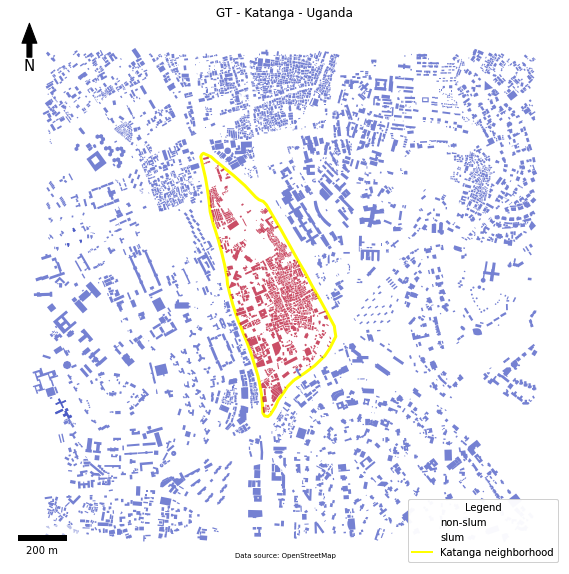

In [45]:

# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))


RB_legend = Line2D([0], [0], color='yellow', lw=2, label='Katanga neighborhood')
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)

ground_truth_gdf.plot(ax=ax, column='label', cmap='coolwarm', alpha=.7, legend=True)

leg = ax.get_legend()

# If the legend is not None, retrieve its handles and labels
if leg:
    handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]
else:
    handles, labels = [], []
# Append the Korail legend entry
handles.append(RB_legend)
labels.append('Katanga neighborhood')


# Create combined legend
combined_legend = ax.legend(handles=handles, labels=labels, loc='lower right', title='Legend')
ax.add_artist(combined_legend)

# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('GT - Katanga - Uganda')
ax.set_axis_off()
plt.show()


In [46]:
print(ground_truth_gdf['label'].value_counts())

non-slum    4375
slum        1091
Name: label, dtype: int64


# Classification method: stepwise searching between defined ranges - Testing in Uganda

In [47]:
#Best Threshold Values from training data (KORAIL)
b_t_area = 61.93477484824078
b_t_per = 352.74298446912377
b_t_mid = 44.35849724422399
b_t_tes_area = 20354.12633413816

# Apply best thresholds to classify buildings
joined_gdf['label'] = np.where(
    (joined_gdf['area'] < b_t_area) &
    (joined_gdf['mean_interbuilding_distance'] < b_t_mid),
    'slum', 'non-slum'
)

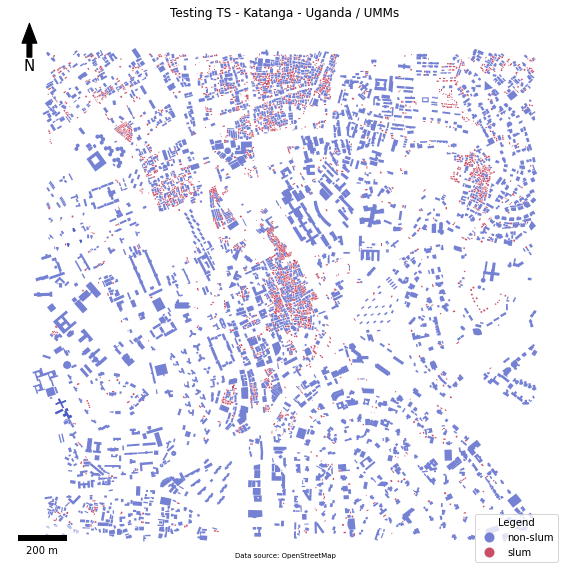

In [48]:
# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))
joined_gdf.plot(column='label', cmap='coolwarm', alpha=.7, legend=True, ax=ax,
                legend_kwds={'loc': 'lower right', 'title': "Legend"})
# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('Testing TS - Katanga - Uganda / UMMs')
ax.set_axis_off()
plt.show()

In [49]:
print(joined_gdf['label'].value_counts())

non-slum    2823
slum        2643
Name: label, dtype: int64


# Testing

In [50]:
# Merge datasets on unique identifier
merged_df = pd.merge(joined_gdf[['uID', 'label']], buildings[['uID', 'label']], on='uID', suffixes=('_pred', '_true'))

In [51]:
print(joined_gdf['label'].value_counts())

non-slum    2823
slum        2643
Name: label, dtype: int64


In [52]:
# Number of correct predictions
correct_predictions = (merged_df['label_pred'] == merged_df['label_true']).sum()

# Total number of predictions
total_predictions = len(merged_df)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 57.45%


In [53]:
# Confusion matrix
conf_matrix = confusion_matrix(merged_df['label_true'], merged_df['label_pred'], labels=['slum', 'non-slum'])



In [54]:
from sklearn.metrics import classification_report

# Classification report
class_report = classification_report(merged_df['label_true'], merged_df['label_pred'], target_names=['slum', 'non-slum'])

print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

        slum       0.86      0.56      0.68      4375
    non-slum       0.27      0.65      0.38      1091

    accuracy                           0.57      5466
   macro avg       0.56      0.60      0.53      5466
weighted avg       0.74      0.57      0.62      5466



In [55]:
#Best Threshold Values from training data (KORAIL)
b_t_area = 61.93477484824078
b_t_per = 352.74298446912377
b_t_mid = 44.35849724422399
b_t_tes_area = 20354.12633413816
b_t_awd = 46.27806593211198

# Apply best thresholds to classify buildings
joined_gdf['label2'] = np.where(
    (joined_gdf['area'] < b_t_area) &
    (joined_gdf['mean_interbuilding_distance'] < b_t_mid) &
    (joined_gdf['avg_weighted_distance'] < b_t_awd),
    'slum', 'non-slum'
)

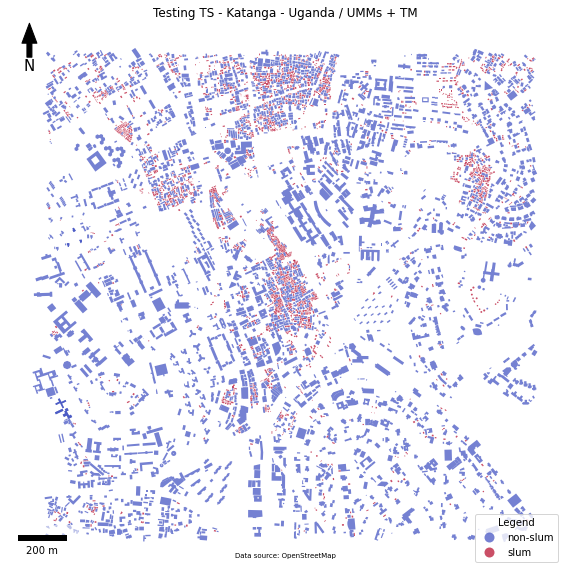

In [56]:
# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))

joined_gdf.plot(column='label2', cmap='coolwarm', alpha=.7, legend=True, ax=ax,
                legend_kwds={'loc': 'lower right', 'title': "Legend"})
# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('Testing TS - Katanga - Uganda / UMMs + TM')
ax.set_axis_off()
plt.show()


In [57]:
print(joined_gdf['label2'].value_counts())

non-slum    2949
slum        2517
Name: label2, dtype: int64


In [58]:
# Merge datasets on unique identifier
merged_df2 = pd.merge(joined_gdf[['uID', 'label2']], buildings[['uID', 'label']], on='uID', suffixes=('_pred', '_true'))
print(merged_df2.columns)

Index(['uID', 'label2', 'label'], dtype='object')


In [59]:
# Number of correct predictions
correct_predictions = (merged_df2['label2'] == merged_df2['label']).sum()

# Total number of predictions
total_predictions = len(merged_df2)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 59.53%
